# Advanced Lane Detection Project

## Steps:
1. Calibrate the camera
2. Apply the distortion correction to raw images
3. Using color and gradient thresholds, a thresholded binary image is created
4. Transform the image to bird's eye-view using a perspecitve transform
5. Detect lane pixels and fit to find lane boundary
6. Determine curvature of the lane and vehicle position with respect to center
7. Warp the detected lane boundaries back to the original lane index
8. Output visual display of the lane boundaries and estimation of lane curvature and vehicle position
9. There after run the algorith on a video

## Camera Calibration

In [1]:
#This will generate a list of object points and its correcponding image points and use it to calibrate the camera by
#generating the camera matrix and distortion coefficients and save them in a pickle file for later use

import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
#%matplotlib qt

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32) #6 x 9 corners
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) #keep the third dimension 0

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname) #cv2 reads in BGR format and mpimg.imread reads in RGB
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)
        #print(fname) #To see which images are used

cv2.destroyAllWindows()

#Use any randomly picked image's size
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
distorion_points_pickle = {}
distorion_points_pickle["mtx"] = mtx
distorion_points_pickle["dist"] = dist
pickle.dump(distorion_points_pickle, open("camera_cal/distorion_points_pickle.p", "wb" ) )

In [3]:
print(objp[12])
print(len(objpoints))
img_size

[ 3.  1.  0.]
17


(1280, 720)

## Undistort Raw Images

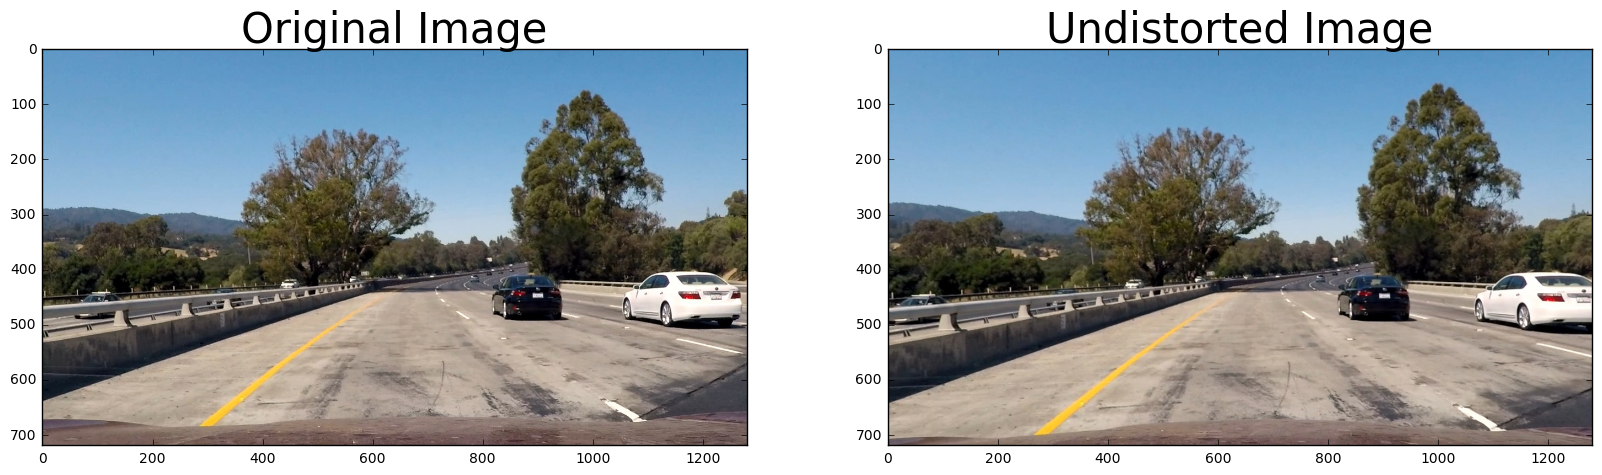

In [4]:
# Test the distorion coefficients
import pickle
%matplotlib inline

dist_pickle = pickle.load( open("camera_cal/distorion_points_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def undistort_image(img, cam_mtx=mtx, dist_coeff=dist):
    #Undistort the image
    undst_img = cv2.undistort(img, cam_mtx, dist_coeff, None, cam_mtx)
    return undst_img

# Test undistortion on an image
#img = cv2.imread('camera_cal/calibration5.jpg')
img = cv2.imread('test_images/test1.jpg')
#img_size = (img.shape[1], img.shape[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #b'cse plt uses images in RGB format whereas CV2 has them in BGR
undist = undistort_image(img)


# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

In [5]:
def region_of_interest(img, vertices): #not much helpful as perspective transform indirectly does similar thing
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    'Vertices' is a 2D array where each row is a vertex of the polygon
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


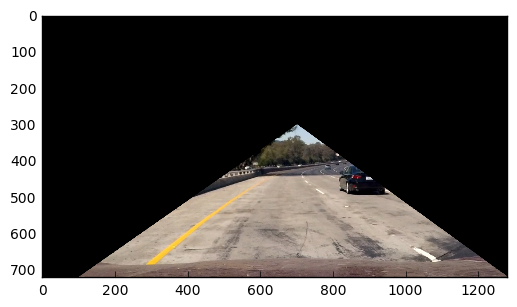

In [6]:
vertices = np.array([[(100,img_size[1]),(700, 300), (700, 300), (img_size[0],img_size[1])]], dtype=np.int32)
    
img_msk = region_of_interest(img,vertices)
plt.imshow(img_msk)
plt.show()

## Color and Gradient Thresholding

In [7]:
#Color thresholding
def color_mask(img):
    #This function picks out yellow and while colors from the image
    
    #convert to HLS
    imgh = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    #yellow mask
    mask1 = (imgh[:,:,0] < 35) & (imgh[:,:,1] < 200) & (imgh[:,:,2] < 255)
    mask2 = (imgh[:,:,0] > 5) & (imgh[:,:,1] > 80) & (imgh[:,:,2] > 120)
    masky = mask1 & mask2

    #white mask
    #mask1 = (imgh[:,:,0] < 170) & (imgh[:,:,1] < 255) & (imgh[:,:,2] < 220)
    mask2 = (imgh[:,:,0] > 20) & (imgh[:,:,1] > 200) & (imgh[:,:,0] > 20)
    maskw = mask2 #mask1 & mask2

    #combine the two masks
    mask = masky | maskw

    #mask_image = np.zeros_like(imgh).astype(np.uint8)
    #mask_image[mask] = [0,255,0] #this is white color in HLS
    #mask_image = cv2.cvtColor(mask_image, cv2.COLOR_HLS2RGB)
    #plt.imshow(mask_image)
    #plt.show()
    
    col_mask = mask
    return col_mask

# Gradient Thresholding
def gradient_mask(img, sobel_kernel=3, th_mag=(10.0, 255), th_dir=(0.0,0.6)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 6) Create a binary mask where mag thresholds are met
    # 7) Use np.arctan2(sobely, sobelx) to calculate the direction of the gradient
    # 8) Create a binary mask where direction thresholds are met
    # 9) combine the two 
    # 7) Return this mask as your binary_output image
    
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #It might be better to find gradient on the L channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) #It performs better when finding gradient on the S channel
    S = hls[:,:,2]
    
#     plt.imshow(gray,cmap='gray')
#     plt.show()
#     plt.imshow(S,cmap='gray')
#     plt.show()
    
    sobelx = cv2.Sobel(S, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(S, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    
    sobelmag = np.sqrt(sobelx**2 + sobely**2)
    sobelmag_scaled = (sobelmag/np.max(sobelmag)*255).astype(np.uint8)
    sobelmag_binary = np.zeros_like(sobelmag_scaled, dtype=np.uint8)
    sobelmag_binary[(sobelmag_scaled > th_mag[0]) & (sobelmag_scaled < th_mag[1])] = 1
    
    eps=1e-9 #for numerical stability
    sobelx[sobelx == 0] = eps
    sobel_dir = np.arctan(sobely/sobelx)
    sobeldir_binary = np.zeros_like(sobel_dir, dtype=np.uint8)
    sobeldir_binary[(sobel_dir < -1*th_dir[0]) & (sobel_dir > -1*th_dir[1])] = 1
    sobeldir_binary[(sobel_dir > th_dir[0]) & (sobel_dir < th_dir[1])] = 1
    
    grad_mask = (sobelmag_binary==1) & (sobeldir_binary==1)
    return grad_mask

#combine gradient and color thresholding
def col_grad_mask(img):
    #img = region_of_interest(img,vertices) #this doesn't help much
    
    col_mask = color_mask(img)
    #tmp = np.zeros_like(img,dtype=np.uint8)
    #tmp[col_mask] = [255,255,255]
    #plt.imshow(tmp)
    #plt.show()

    grad_mask = gradient_mask(img) #, th_mag=(80,255), th_dir=(0.2,1.6))
    #tmp = np.zeros_like(img,dtype=np.uint8)
    #tmp[grad_mask] = [255,255,255]
    #plt.imshow(tmp)
    #plt.show()

    comb_mask = col_mask | grad_mask
    #tmp = np.zeros_like(img,dtype=np.uint8)
    #tmp[comb_mask] = [255,255,255]
    #plt.imshow(tmp)
    #plt.show()
    return comb_mask

In [8]:
# def col_grad_mask_from_lectures(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
#     img = np.copy(img)
#     # Convert to HSV color space and separate the V channel
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
#     l_channel = hsv[:,:,1]
#     s_channel = hsv[:,:,2]
    
#     # Sobel x
#     sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
#     abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
#     scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))    
#     # Threshold x gradient
#     sxbinary = np.zeros_like(scaled_sobel)
#     sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
#     # Threshold color channel
#     s_binary = np.zeros_like(s_channel)
#     s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

#     # Stack each channel
#     # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
#     # be beneficial to replace this channel with something else.
#     color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
#     # Combine the two binary thresholds
#     combined_binary = np.zeros_like(sxbinary)
#     combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
#     combined_binary = combined_binary==1
                
#     return combined_binary

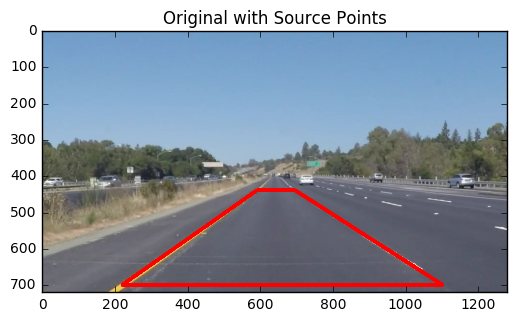

[[ -7.79088301e-01  -1.57810010e+00   1.13749123e+03]
 [ -1.06581410e-14  -2.01976411e+00   8.88696207e+02]
 [ -1.49619900e-17  -2.47051323e-03   1.00000000e+00]]
8 Degrees of Freedom. And 3x3 due to the 2D points are transformed into 3D homogeneous coordinates


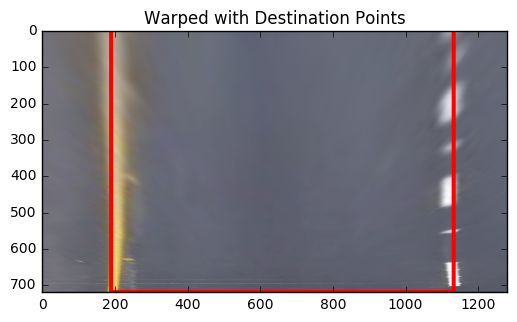

In [9]:
img = cv2.imread('test_images/solidYellowLeft.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #b'cse plt uses images in RGB format whereas CV2 has them in BGR
img = cv2.resize(img, img_size)
undist = undistort_image(img) #undostort the image
#plt.imshow(undist)
#plt.show()

temp = np.copy(img)
pt1 = (220,700)
pt2 = (590,440)
pt3 = (1100,700)
pt4 = (695,440)

dpt1 = [190,720]
dpt2 = [190,0]
dpt3 = [1130,720]
dpt4 = [1130,0]

#cv2.line(orig_image,pt1,pt2,rgb_color,line_thickness)
cv2.line(temp,pt1,pt2,(255,0,0),10)
cv2.line(temp,pt3,pt4,(255,0,0),10)
cv2.line(temp,pt1,pt3,(255,0,0),10)
cv2.line(temp,pt2,pt4,(255,0,0),10)
plt.title('Original with Source Points')
plt.imshow(temp)
plt.show()

src_points = np.float32([list(pt1),list(pt2),list(pt3),list(pt4)])
dest_points = np.float32([dpt1,dpt2,dpt3,dpt4])

#Top-down perspective transformation matrix
def top_down_transformation(src_points=src_points, dest_points=dest_points):
    transformation_Matrix = cv2.getPerspectiveTransform(src_points,dest_points)
    return transformation_Matrix
trans_mat = top_down_transformation()
inv_trans_mat = np.linalg.inv(trans_mat)
print(trans_mat)
print('8 Degrees of Freedom. And 3x3 due to the 2D points are transformed into 3D homogeneous coordinates')
#unwarp an image to top_down
def warp(img, trans_mat=trans_mat, img_size=img_size):
    warped = cv2.warpPerspective(img, trans_mat, img_size, flags=cv2.INTER_LINEAR)
    #print(trans_mat)
    return warped

warped = warp(img)
cv2.line(warped,tuple(dpt1),tuple(dpt2),(255,0,0),10)
cv2.line(warped,tuple(dpt3),tuple(dpt4),(255,0,0),10)
cv2.line(warped,tuple(dpt1),tuple(dpt3),(255,0,0),10)
cv2.line(warped,tuple(dpt2),tuple(dpt4),(255,0,0),10)
plt.title('Warped with Destination Points')
plt.imshow(warped)
plt.show()


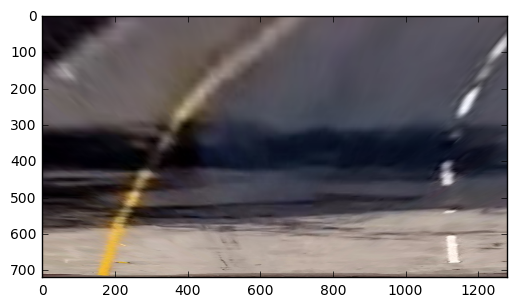

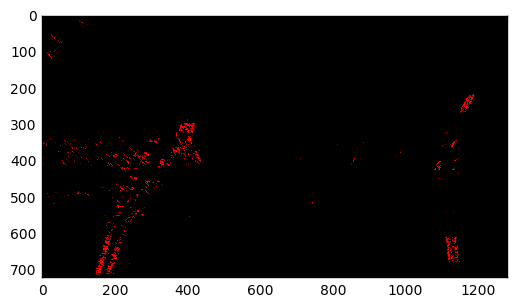

In [10]:
images = glob.glob('test_images/test5.jpg') #/*.jpg')

# Step through all the test images
for idx, fname in enumerate(images):
    img_tmp = cv2.imread(fname)
    img_tmp = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2RGB)
    img_tmp = cv2.resize(img_tmp, img_size)
    img_tmp2 = warp(img_tmp)
    plt.imshow(img_tmp2)
    plt.show()
    comb_mask = gradient_mask(img_tmp2)
    img_tmp3 = np.zeros_like(img_tmp2,dtype=np.uint8)
    img_tmp3[comb_mask] = [255,0,0]
    plt.imshow(img_tmp3)
    plt.show()

In [11]:
img_size

(1280, 720)

In [22]:
def calc_curvature(yval,lane_fit):
    A,B,C = lane_fit
    curvature = ((1+(2*A*yval+B)**2)**(3/2))/(2*np.absolute(A))
    return curvature
    
def hist_search(warped_lanes,img_size=img_size):
    #warped lanes is a grayscale image
    warped_lanes_detected = np.copy(warped_lanes)
    warped_lanes_final = np.zeros_like(warped_lanes,dtype=np.uint8)

#     plt.imshow(warped_lanes,cmap='gray')
#     plt.show()
    
    num_seg = 8
    seg_ht = img_size[1]/num_seg #segment height (90 segments, 720/8=90)
    assert(seg_ht % 2 == 0), 'Number of segments not correct!'
    seg_ht = int(seg_ht) #only if it is even else will stop at the previous line and assert error message
    seg_wt = 50*3 #segment width (is actually 2x this value)
    
    histogram = np.mean(warped_lanes[int(img_size[1]/2):,:],axis=0) #bottom half of the image
    left_init = np.argmax(histogram[0:int(img_size[0]/2)])
    right_init = np.argmax(histogram[int(img_size[0]/2):]) + int(img_size[0]/2)

    prev_peak = [left_init,right_init]
    prev_peak_disp = [0,0]
    
    left_peak=0
    right_peak=0
    
    left_lanes_pix = ()
    right_lanes_pix = ()
    
    for ii in range(num_seg): #8 segments
        stp_r = img_size[1] - seg_ht*ii
        strt_r = stp_r - seg_ht
        
        #Left Lane
        strt_c = prev_peak[0]-seg_wt
        stp_c = prev_peak[0]+seg_wt
        if strt_c < 0: strt_c = 0
        if strt_c > img_size[0]-seg_wt: strt_c=img_size[0]-seg_wt
        if stp_c < seg_wt: stp_c = seg_wt
        if stp_c > img_size[0]: stp_c = img_size[0]
        
        #find the left lane pixels
        lanes_pix = np.nonzero(warped_lanes[strt_r:stp_r,strt_c:stp_c])
        lanes_pix = (lanes_pix[0]+strt_r,lanes_pix[1]+strt_c)
        warped_lanes_final[lanes_pix] = 1
        
        #draw the sliding window on a separate image
        top_left = (strt_c,strt_r)
        bot_right = (stp_c,stp_r)
        #actually no need to check if the corners are within the image dimensions. 
        #cv2.rect() will set their max/min values to the image dimensions
        warped_lanes_detected = cv2.rectangle(warped_lanes_detected,top_left,bot_right,(1,1,1),1) #negative width means its a filled rectangle

        #find the peak value to be used for the next sliding window
        left_hist = warped_lanes[strt_r:stp_r,strt_c:stp_c]
        left_hist = np.mean(left_hist, axis=0)
        #print(left_hist.shape)
        #use prev_window value if very few pixels in the window
        #Then for contour plotting only, use the previous value. But don't do this for fitting purposes
        if np.max(left_hist) < 0.1:
            left_peak = prev_peak[0] + prev_peak_disp[0]
            
        else:
            left_peak = np.argmax(left_hist) + strt_c
    
        prev_peak_disp[0] = left_peak - prev_peak[0]
        prev_peak[0] = left_peak
        #
        #
        #Right Lane
        strt_c = prev_peak[1]-seg_wt
        stp_c = prev_peak[1]+seg_wt
        if strt_c < 0: strt_c = 0
        if strt_c > img_size[0]-seg_wt: strt_c=img_size[0]-seg_wt
        if stp_c < seg_wt: stp_c = seg_wt
        if stp_c > img_size[0]: stp_c = img_size[0]
                
        #find the right lane pixels
        lanes_pix = np.nonzero(warped_lanes[strt_r:stp_r,strt_c:stp_c])
        lanes_pix = (lanes_pix[0]+strt_r,lanes_pix[1]+strt_c)
        warped_lanes_final[lanes_pix] = 1
        
        #draw the sliding window on a separate image
        top_left = (strt_c,strt_r)
        bot_right = (stp_c,stp_r)
        #actually no need to check if the corners are within the image dimensions. 
        #cv2.rect() will set their max/min values to the image dimensions
        warped_lanes_detected = cv2.rectangle(warped_lanes_detected,top_left,bot_right,(1,1,1),1) #negative width means its a filled rectangle

        #find the peak value to be used for the next sliding window
        right_hist = warped_lanes[strt_r:stp_r,strt_c:stp_c]
        right_hist = np.mean(right_hist, axis=0)
        #print(right_hist.shape)
        #use prev_window value if very few pixels in the window
        #Then for contour plotting only, use the previous value. But don't do this for fitting purposes
        if np.max(right_hist) < 0.1:
            right_peak = prev_peak[1] + prev_peak_disp[1]
            
        else:
            right_peak = np.argmax(right_hist) + strt_c
    
        prev_peak_disp[1] = right_peak - prev_peak[1]
        prev_peak[1] = right_peak
        #
        #
        #print(left_peak,right_peak)
        #print(prev_peak_disp[0],prev_peak_disp[1])
        #print()
        
    #find the left and right pixel points for curve fitting
    left_lanes_pix = np.nonzero(warped_lanes_final[:,0:int(img_size[0]/2)])
    right_lanes_pix = np.nonzero(warped_lanes_final[:,int(img_size[0]/2):])
    right_lanes_pix = (right_lanes_pix[0],right_lanes_pix[1] + int(img_size[0]/2))
    xleft_list = left_lanes_pix[1]
    yleft_list = left_lanes_pix[0]
    xright_list = right_lanes_pix[1]
    yright_list = right_lanes_pix[0]
    
    yy_list = [0,0,0]
    left_fitx = [0,0,0]
    right_fitx = [0,0,0]
    if (yleft_list.shape[0] > 1) and (xleft_list.shape[0] > 1) and (yright_list.shape[0] > 1) and (xright_list.shape[0] > 1):
        left_fit = np.polyfit(yleft_list,xleft_list,2)
        right_fit = np.polyfit(yright_list,xright_list,2)  
    
        yy_list = np.arange(int(img_size[1]*0.3),int(img_size[1]*1),1,dtype=np.uint32)
        left_fitx = np.uint32(left_fit[0]*yy_list**2 + left_fit[1]*yy_list + left_fit[2])
        right_fitx = np.uint32(right_fit[0]*yy_list**2 + right_fit[1]*yy_list + right_fit[2])
        #make sure the fit lines are within the image dimenesions
        left_fitx[left_fitx >= img_size[0]] = img_size[0]-1 
        left_fitx[left_fitx < 0] = 0
        right_fitx[right_fitx >= img_size[0]] = img_size[0]-1 
        right_fitx[right_fitx < 0] = 0
        
    fit_lanes = (yy_list,left_fitx,right_fitx)

            
#     plt.title('Histogram')
#     plt.plot(histogram)
#     plt.show()

#     plt.title('Warped Lanes Detected')
#     plt.imshow(warped_lanes_detected, cmap='gray')
#     plt.show()
    
#     plt.title('Warped Lanes Final')
#     plt.imshow(warped_lanes_final, cmap='gray')
#     plt.show()
    
#     plt.plot(left_list,yleft_list,'ro', left_fitx,yy_list,'b-')
#     plt.plot(right_list,yright_list,'ro', right_fitx,yy_list,'b-')
#     plt.xlim(0,1280)
#     plt.ylim(0,720)
#     plt.gca().invert_yaxis() #to make the yaxis look like in an image
#     plt.show()
    
    #calculate curvature
    # Define conversions in x and y from pixels space to meters
    curvature = (0,0)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension 700 or 1280??
    if (yleft_list.shape[0] > 1) and (xleft_list.shape[0] > 1) and (yright_list.shape[0] > 1) and (xright_list.shape[0] > 1):
        left_fit_cr = np.polyfit(yleft_list*ym_per_pix,xleft_list*xm_per_pix,2)
        right_fit_cr = np.polyfit(yright_list*ym_per_pix,xright_list*xm_per_pix,2)  
    
        yval = img_size[1]-50*2
        left_curvature = calc_curvature(yval,left_fit_cr)
        right_curvature = calc_curvature(yval,right_fit_cr)
        curvature = (left_curvature,right_curvature)
        #print('Left Curvature is: ', left_curvature)
        #print('Right Curvature is: ', right_curvature)

    
#     fit_lanes_plt = np.zeros((img_size[1],img_size[0],3),dtype=np.uint8)
#     fit_lanes_plt[yy_list,left_fitx] = [255,0,0]
#     fit_lanes_plt[yy_list,right_fitx] = [0,0,255]
#     plt.title('Fit Lanes')
#     plt.imshow(fit_lanes_plt)
#     plt.show()
    
        
    #lane center
    lane_cent = np.mean([left_fitx[-1],right_fitx[-1]])
    car_cent = img_size[0]/2 #center of the camera is the car center
    off_cent = (car_cent-lane_cent)*xm_per_pix #negative means car's on the left of the lance center and positive means right (in meters)
    print(lane_cent, car_cent)
    
    #print(left_list)
    #print(right_list)
    return warped_lanes_final, fit_lanes, curvature, off_cent

def final_image(warped, fit_lanes, inv_trans_mat=inv_trans_mat, undist=undist):
    yy_list,left_fitx,right_fitx = fit_lanes
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero,warp_zero,warp_zero))
    
    pts_left = np.array([np.transpose(np.vstack((left_fitx,yy_list)))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack((right_fitx,yy_list))))])
    pts = np.hstack((pts_left,pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,266,0))
    new_warp = warp(color_warp, trans_mat=inv_trans_mat)
    result = cv2.addWeighted(undist,1,new_warp,0.3,0)

    return result
    

In [23]:
def color_fit_lines(warped_lanes_new):
    #to color the curve fitted left lane blue and right red
    warped_lanes_newc = cv2.cvtColor(warped_lanes_new*255,cv2.COLOR_GRAY2RGB)
    #Make left lane be red color
    tmp1 = warped_lanes_newc[:,0:int(img_size[0]/2),1]
    tmp2 = tmp1 == 255
    tmp1[tmp2] = 0
    tmp1 = warped_lanes_newc[:,0:int(img_size[0]/2),2]
    tmp2 = tmp1 == 255
    tmp1[tmp2] = 0
    #Make right lane be blue color
    tmp1 = warped_lanes_newc[:,int(img_size[0]/2):img_size[0],0]
    tmp2 = tmp1 == 255
    tmp1[tmp2] = 0
    tmp1 = warped_lanes_newc[:,int(img_size[0]/2):img_size[0],1]
    tmp2 = tmp1 == 255
    tmp1[tmp2] = 0
    return warped_lanes_newc

def pipeline(img):
    img = cv2.resize(img, img_size)
#     plt.title('Original')
#     plt.imshow(img)
#     plt.show()

    undist = undistort_image(img) #undostort the image
    warped = warp(img)
    
#     plt.title('Warped')
#     plt.imshow(warped)
#     plt.show()
    
    comb_mask = col_grad_mask(warped)
    warped_gray = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
    warped_lanes = np.zeros_like(warped_gray,dtype=np.uint8)
    warped_lanes[comb_mask] = 1 #white in gray scale #[255,255,255] #white in RGB

#     plt.title('Warped Lanes')
#     plt.imshow(warped_lanes, cmap='gray')
#     plt.show()

    warped_lanes_new, fit_lanes, curvature, off_cent = hist_search(warped_lanes)
    
    yy_list,left_fitx,right_fitx = fit_lanes
    warped_lanes_new[yy_list,left_fitx] = 1
    warped_lanes_new[yy_list,right_fitx] = 1
    
#     print(warped_lanes_new.shape)
#     print(img_size)

#     plt.title('Warped Lanes New')
#     plt.imshow(warped_lanes_new, cmap='gray')
#     plt.show()
    
    #color the fit lines. Left is blue and right is red
    warped_lanes_newc = color_fit_lines(warped_lanes_new)
    
    final_img = final_image(warped_lanes_new, fit_lanes, inv_trans_mat, undist)
    left_curvature = 'Left Curvature: ' + str(int(curvature[0])) + 'm'
    right_curvature = 'Right Curvature: ' + str(int(curvature[1])) + 'm'
    off_cent = 'Distance Off Center: ' + str(off_cent) + 'm'
    # Write some Text
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(final_img,left_curvature,(60,60), font, 1,(255,255,255),4)
    cv2.putText(final_img,right_curvature,(60,120), font, 1,(255,255,255),4)
    cv2.putText(final_img,off_cent,(60,180), font, 1,(255,255,255),4)
    
#     plt.title('Final Image')
#     plt.imshow(final_img)
#     plt.show()
    
    
#     plt.title('Colored Warped Lanes New')
#     plt.imshow(warped_lanes_newc)
#     plt.show()
    

    warped_rec = warp(warped_lanes, trans_mat=inv_trans_mat)
#     plt.title('Warped Recovered Lanes')
#     plt.imshow(warped_rec)
#     plt.show()
    
    warped_rec = warp(warped, trans_mat=inv_trans_mat)
#     plt.title('Warped Recovered')
#     plt.imshow(warped_rec)
#     plt.show()
    return final_img

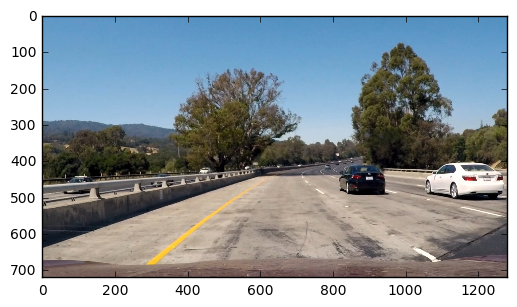

702.0 640.0


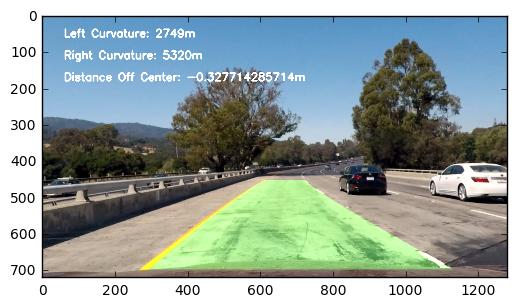

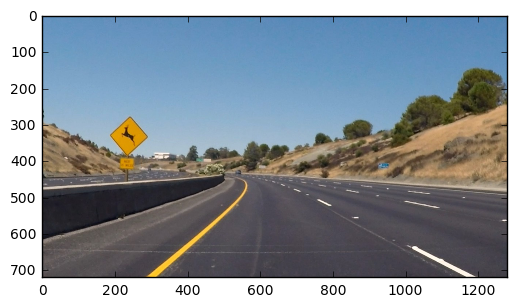

730.0 640.0


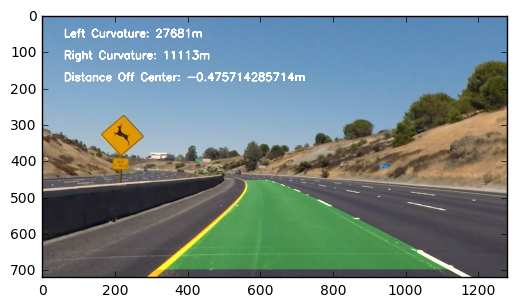

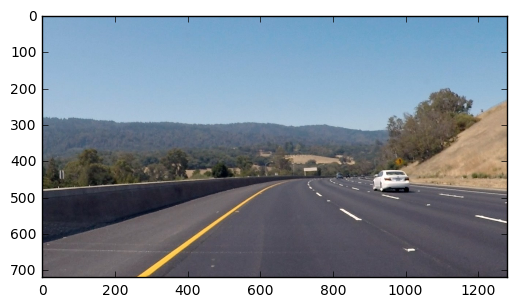

715.5 640.0


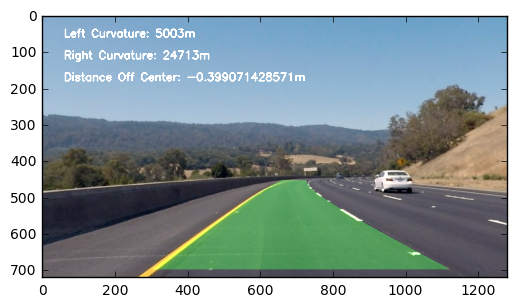

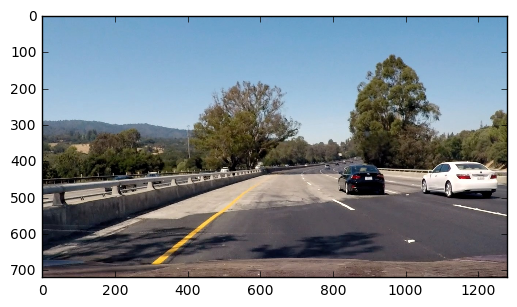

732.5 640.0


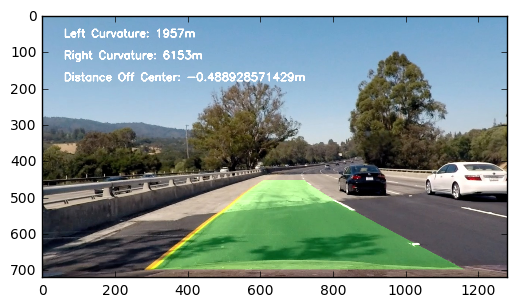

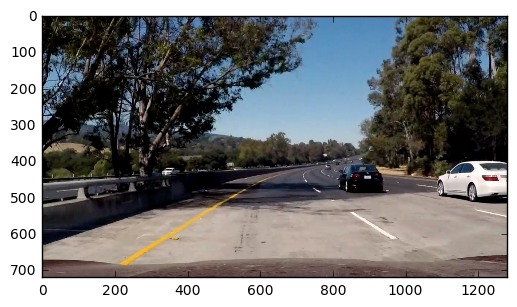

666.0 640.0


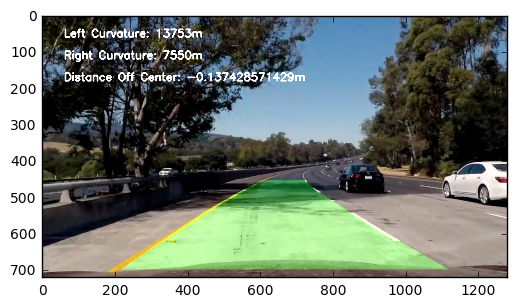

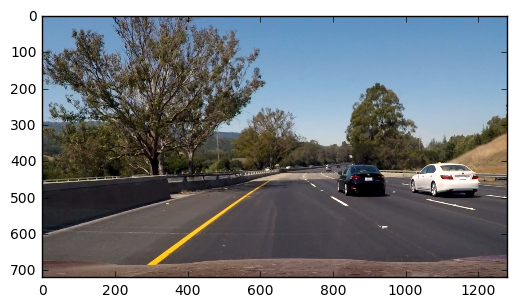

724.5 640.0


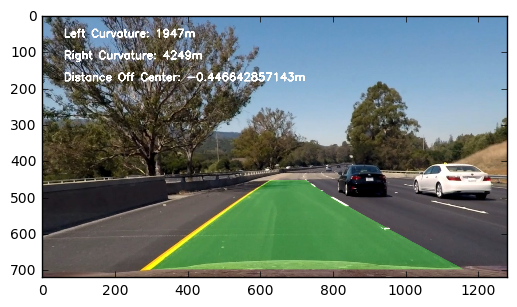

In [24]:
images = glob.glob('test_images/test*.jpg') #/*.jpg')

# Step through all the test images
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #b'cse plt uses images in RGB format whereas CV2 has them in BGR
    plt.imshow(img)
    plt.show()
    final_img = pipeline(img)
    plt.imshow(final_img)
    plt.show()
    cv2.waitKey(500)
    

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
prj_output = 'prj_output.mp4'
vid = VideoFileClip('project_video.mp4')
output_clip = vid.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(prj_output, audio=False)

739.5 640.0
[MoviePy] >>>> Building video prj_output.mp4
[MoviePy] Writing video prj_output.mp4


  0%|                                                 | 0/1261 [00:00<?, ?it/s]

739.5 640.0


  0%|                                         | 1/1261 [00:00<03:56,  5.32it/s]

738.0 640.0


  0%|                                         | 2/1261 [00:00<03:48,  5.50it/s]

739.0 640.0


  0%|                                         | 3/1261 [00:00<03:49,  5.49it/s]

741.0 640.0


  0%|▏                                        | 4/1261 [00:00<03:46,  5.56it/s]

741.5 640.0


  0%|▏                                        | 5/1261 [00:00<03:40,  5.71it/s]

746.0 640.0


  0%|▏                                        | 6/1261 [00:01<03:31,  5.93it/s]

746.5 640.0


  1%|▏                                        | 7/1261 [00:01<03:26,  6.06it/s]

746.0 640.0


  1%|▎                                        | 8/1261 [00:01<03:13,  6.48it/s]

746.0 640.0


  1%|▎                                        | 9/1261 [00:01<03:08,  6.64it/s]

744.5 640.0


  1%|▎                                       | 10/1261 [00:01<03:05,  6.73it/s]

745.5 640.0


  1%|▎                                       | 11/1261 [00:01<02:56,  7.10it/s]

745.5 640.0


  1%|▍                                       | 12/1261 [00:01<02:59,  6.95it/s]

744.0 640.0


  1%|▍                                       | 13/1261 [00:02<02:53,  7.19it/s]

745.0 640.0


  1%|▍                                       | 14/1261 [00:02<02:49,  7.35it/s]

742.5 640.0


  1%|▍                                       | 15/1261 [00:02<02:46,  7.50it/s]

741.0 640.0


  1%|▌                                       | 16/1261 [00:02<02:43,  7.61it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(prj_output))

In [ ]:
# cap = cv2.VideoCapture('project_video.mp4')
# print(cap.open('project_video.mp4'))
# print(cap.isOpened())

# while(True):
#     #capture fram by frame
#     ret,frame = cap.read()
#     #processing
#     final_img = pipeline(frame)
#     final_img = cv2.cvtColor(final_img,cv2.COLOR_RGB2BGR)
#     cv2.imshow('final_img', final_img)
#     cv2.waitKey(25)

# vid.release()
# cv2.destroyAllWindows()
    

## This is just test code

In [ ]:
#Using HLS color scheme: 
#For yellow color can vary H from 25 to 35 and L from L from 80 to 200 and S from 120 to 255 to get different variations
#For white color can vary H from -5 to +5 and L from L from 220 to 255 and S from 0 to 20 to get different variations
#For white the Hue value is not thatsensitive. L is very sensitive. So can just keep H=0
#Find HLS values to threshold
def plot_test_rgb(rgb):
    tmp_col = np.zeros((40,40,3)).astype(np.uint8) #40x40 colored image
    tmp_col += rgb
    plt.imshow(tmp_col) #plt.imshow plots in RGB by default cmap=None
    plt.show()
    
def plot_test_hsv(hsv):
    tmp_col = np.zeros((40,40,3)).astype(np.uint8) #404x40 colored image
    tmp_col += hsv
    tmp_col = cv2.cvtColor(tmp_col,cv2.COLOR_HSV2RGB)
    plt.imshow(tmp_col) #plt.imshow plots in RGB by default cmap=None
    plt.show()

def plot_test_hls(hls):
    tmp_col = np.zeros((40,40,3)).astype(np.uint8) #404x40 colored image
    tmp_col += hls
    tmp_col = cv2.cvtColor(tmp_col,cv2.COLOR_HLS2RGB)
    plt.imshow(tmp_col) #plt.imshow plots in RGB by default cmap=None
    plt.show()
    
yellow = np.uint8([[[255,255,255]]])
#print(yellow.shape)
plot_test_rgb(yellow)

hls_yellow = cv2.cvtColor(yellow,cv2.COLOR_RGB2HLS)
#print(hls_yellow.shape)
print(hls_yellow)
plot_test_hls(hls_yellow)

hls_yellow_low = np.copy(hls_yellow)
hls_yellow_low[0,0,0] = 0 #hls_yellow[0,0,0] + 0 #5
hls_yellow_low[0,0,1] = 220 #128 #200 #80
hls_yellow_low[0,0,2] = 0 #255 #120
plot_test_hls(hls_yellow_low)

#But instead of searching for just white and yellow lanes, it might be better to threshold the S channel 
#to find lanes of even different colors?